## To - Do



---


## Code:
### *   Create Predict script
### *   Integrate holidays andd marketing expense data
### *   implement K-Fold Cross validation
### *   Optimize

---


## * Documentation:
### * Create description file with reasons for the decisions made and code description
### * Compile code into files 




---



# Mount Google Drive

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#Check if it is mounted
#!ls /content/drive
!echo "Working Directory: " "$(pwd)"
!echo "Contents of default folder: " 
!ls
!echo "Contents of Python folder: " 
!ls /content/drive/Python

Working Directory:  /content
Contents of default folder: 
adc.json  drive  sample_data
Contents of Python folder: 
agg_after_dropnan.csv	holidays.csv		 sample_submission.csv
agg_before_dropnan.csv	holidays.xlsx		 train.csv
agg.csv			pollution.csv		 yds_test2018.csv
air_pollution.csv	promotional_expense.csv  yds_train2018.csv
dataset			reframed.csv


In [0]:
!pip install xlrd # needed for read+excel to work

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# CODE

## Basic Imports

In [0]:
from math import sqrt
from numpy import ceil
from numpy import array
from numpy import concatenate
from numpy import split
from matplotlib import pyplot
from pandas import to_numeric
from pandas import read_csv
from pandas import read_excel
from pandas import get_dummies
from pandas import DataFrame
from pandas import Series
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers.core import Activation, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import SGD
from keras.callbacks import ProgbarLogger, EarlyStopping, ModelCheckpoint, TensorBoard


## Compile data into simple data sources

### Compile  training data

In [0]:
#Import data from a excel file
train_dataset = read_csv('/content/drive/Python/yds_train2018.csv', header=0, index_col=0)

#Delete Unnecessary columns
del train_dataset['Merchant_ID']
del train_dataset['Week']

# Group by and sum sales
train_dataset =  train_dataset.groupby(['Year','Month','Product_ID','Country']).sum().reset_index()

# Convert to one hot vector
train_dataset= get_dummies(train_dataset, columns=["Country"], prefix=[None])

train_dataset = train_dataset[['Year','Month','Product_ID', 'Argentina', 'Belgium','Columbia', 'Denmark', 'England', 'Finland', 'Sales']]
train_dataset.sort_values(['Year','Month','Product_ID', ]) #

train_dataset.to_csv('/content/drive/Python/train.csv')



#!ls /content/drive/Python

### Compile Prediction Data

In [0]:
#Import data from a excel file
test_dataset = read_csv('/content/drive/Python/yds_test2018.csv', header=0, index_col=0)

test_dataset['Sales'] =float(0)
#Convert to one hot vector encoding for countries.
test_dataset=get_dummies(test_dataset, columns=["Country"], prefix=[None])

test_dataset = test_dataset[['Year','Month','Product_ID','Argentina','Belgium','Columbia', 'Denmark', 'England', 'Finland' , 'Sales']]   ###change this

#print test_dataset.columns
#print test_dataset.dtypes
test_dataset.to_csv('/content/drive/Python/predict.csv')

!ls /content/drive/Python

Country_Argentina_train.csv  holidays.xlsx	      temp.ods
Country_Belgium_train.csv    Models		      temp.ods (f57205fa)
Country_Columbia_train.csv   predict.csv	      test.csv
Country_Denmark_train.csv    predict.ods	      train.csv
Country_England_train.csv    promotional_expense.csv  yds_test2018.csv
Country_Finland_train.csv    sample_submission.csv    yds_train2018.csv
holidays.csv		     temp.csv		      ZS_Challenge


### Compile_holidays_data

In [0]:
#convert given data into mapping from \(Country_id,year,month) --->\(number of holidays)
    
#Import data from a excel file
hdata = read_excel('/content/drive/Python/holidays.xlsx',sheet_name=0,header=0)

#Split the date column into 3 columns
hdata['Date'] = hdata['Date'].str.split(', ')
date_cols = hdata['Date'].apply(Series)

#remove redundant columns
del hdata['Date']
del hdata['Holiday']
#del date_cols[2]

# rename each resultant variable with column name
c = ['Year', 'Month','Week']
date_cols = date_cols.rename(columns = lambda i : c[i])

#concatenate the new columns
hdata = concat([hdata[:], date_cols[:]], axis=1)
 
#Convert year and month column data types to uint16
hdata['Year'] = hdata['Year'].astype('uint16')
hdata['Month'] = hdata['Month'].astype('uint16')
hdata['Week'] = (hdata['Week'].astype('uint16') /7).apply(ceil)



#Group by year month and country for number of holidays in each month,year of a country
hdata = hdata.groupby(['Year','Month','Week','Country']).size().reset_index(name='Holidays')

#Convert to one hot vector encoding for countries.
hdata=get_dummies(hdata, columns=["Country"], prefix=[None])

#print hdata

#print hdata.dtypes
hdata.to_csv('/content/drive/Python/holidays.csv')

In [0]:
!ls drive/Python

holidays.csv   predict.ods		temp.ods	     train.ods
holidays.xlsx  promotional_expense.csv	temp.ods (f57205fa)  yds_test2018.csv
Models	       sample_submission.csv	test.csv	     yds_train2018.csv
predict.csv    temp.csv			train.csv	     ZS_Challenge


## Fit Model

### Data Prepartaion Training & Test 

In [0]:
#--------------------------- Common variables --------------------------------------------
input_time_step = 5
forecast_time_step = 1

#---------------------------- Import & transform data ----------------------------
train_data = read_csv('/content/drive/Python/train.csv', header=0, index_col=0)
train_values = train_data.values
train_values = train_values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
train_values = scaler.fit_transform(train_values)

train_df_x = DataFrame(train_values[:,:-1])
train_df_y = DataFrame(train_values[:,-1])


predict_head_x = DataFrame(train_df_x.values[-input_time_step:,:])
predict_head_y = DataFrame(train_df_y.values[-input_time_step:,:])
print df_x.shape

n_features =  train_df_x.shape[1]  #target variable is also included
in_arr = []
out_arr = []

for i in range(input_time_step, 0, -1):
    in_arr.append(train_df_x.shift(i))
    out_arr.append(train_df_y.shift(i))
for i in range(0, forecast_time_step):
    in_arr.append(train_df_x.shift(-i))
    out_arr.append(train_df_y.shift(-i))

train_df_x = concat(in_arr, axis=1)
train_df_x = train_df_x.dropna()
train_df_y = concat(out_arr, axis=1)
train_df_y = train_df_y.dropna()

in_arr = train_df_x.values.reshape((train_df_x.shape[0], input_time_step+1, n_features))
out_arr = train_df_y.values.reshape((train_df_y.shape[0], train_df_y.shape[1]))

# ------------ Split train and test data
train_in_arr, test_in_arr = split(in_arr, [int(.8*len(in_arr))])
train_out_arr, test_out_arr = split(out_arr, [int(.8*len(out_arr))])

#------------------------------------------ Predict---------------------------------------------
predict_data = read_csv('/content/drive/Python/predict.csv', header=0, index_col=0)
predict_values = predict_data.values
predict_values = predict_values.astype('float32')
predict_values = scaler.fit_transform(predict_values)


predict_n_features =  predict_values.shape[1] -1 # the variable to be predicted is also included here


predict_df_x = DataFrame(predict_values[:,:-1])
predict_df_y = DataFrame(predict_values[:,-1])

predict_df_x = concat([predict_head_x, predict_df_x])
predict_df_y = concat([predict_head_y, predict_df_y])

predict_df_x.to_csv('drive/Python/predict_df_x.csv')
predict_df_y.to_csv('drive/Python/predict_df_y.csv')                  

predict_in_arr = []
predict_out_arr = []

for i in range(input_time_step, 0, -1):
    predict_in_arr.append(predict_df_x.shift(i))
    predict_out_arr.append(predict_df_y.shift(i))
for i in range(0, forecast_time_step):
    predict_in_arr.append(predict_df_x.shift(-i))
    predict_out_arr.append(predict_df_y.shift(-i))


predict_df_x = concat(predict_in_arr, axis=1)
predict_df_x = predict_df_x.dropna()
predict_df_y = concat(predict_out_arr, axis=1)
predict_df_y = predict_df_y.dropna()


predict_in_arr = predict_df_x.values.reshape((predict_df_x.shape[0], input_time_step+1, predict_n_features))
predict_out_arr = predict_df_y.values.reshape((predict_df_y.shape[0], predict_df_y.shape[1]))

print type(predict_in_arr), type(predict_out_arr)
print predict_in_arr.shape, predict_out_arr.shape


(383, 54)
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
(105, 6, 9) (105, 6)


### Design Network & Fit Model

In [0]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(input_time_step+1,n_features ), dropout=0.25, recurrent_dropout=0.2, return_sequences =True))
model.add(LSTM(32, dropout=0.25, recurrent_dropout=0.2))
'''model.add(LSTM(32, dropout=0.25, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(16, dropout=0.25, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(8, dropout=0.25, recurrent_dropout=0.2))'''
model.add(Dense(input_time_step+1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  #SGD(lr=0.008, decay=1e-6, momentum=0.9, nesterov=True)
model.summary()

# Save the model according to the conditions  
progbar = ProgbarLogger(count_mode='steps')
checkpoint = ModelCheckpoint("/content/drive/Python/Models/forecast_{epoch:02d}.hdf5", monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=10)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=1, verbose=1, mode='auto')



history = model.fit(train_in_arr, train_out_arr, epochs=200, batch_size = 72,callbacks=[checkpoint], validation_data=(test_in_arr, test_out_arr),verbose=2, shuffle=False)
'''
for i in range(len(Output_array)):
    #print 'Train_input', Input_array[i][0].shape
    #print  'Train_output', Output_array[i][0].shape
    history = model.fit(Input_array[i][0], Output_array[i][0], epochs=50, batch_size = 16,callbacks=[checkpoint], validation_data=(Input_array[i][1], Output_array[i][1]),verbose=2, shuffle=False)
'''


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_127 (LSTM)              (None, 6, 64)             18944     
_________________________________________________________________
lstm_128 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_61 (Dense)             (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________
Train on 306 samples, validate on 77 samples
Epoch 1/200
 - 18s - loss: 0.0448 - acc: 0.2124 - val_loss: 0.0669 - val_acc: 0.2208
Epoch 2/200
 - 0s - loss: 0.0376 - acc: 0.2190 - val_loss: 0.0606 - val_acc: 0.2597
Epoch 3/200
 - 0s - loss: 0.0349 - acc: 0.2582 - val_loss: 0.0584 - val_acc: 0.1948
Epoch 4/200
 - 0s - loss: 0.0340 - acc: 0.2386 - val_loss: 0.0578 - val_acc: 0.1818
Epoch 5/200
 - 0s - 

Epoch 26/200
 - 0s - loss: 0.0272 - acc: 0.4183 - val_loss: 0.0452 - val_acc: 0.4675
Epoch 27/200
 - 0s - loss: 0.0271 - acc: 0.4183 - val_loss: 0.0451 - val_acc: 0.4416
Epoch 28/200
 - 0s - loss: 0.0268 - acc: 0.4477 - val_loss: 0.0447 - val_acc: 0.4805
Epoch 29/200
 - 0s - loss: 0.0264 - acc: 0.4346 - val_loss: 0.0439 - val_acc: 0.4935
Epoch 30/200
 - 0s - loss: 0.0262 - acc: 0.4444 - val_loss: 0.0429 - val_acc: 0.5065

Epoch 00030: saving model to /content/drive/Python/Models/forecast_30.hdf5
Epoch 31/200
 - 0s - loss: 0.0267 - acc: 0.4248 - val_loss: 0.0424 - val_acc: 0.4935
Epoch 32/200
 - 0s - loss: 0.0253 - acc: 0.4412 - val_loss: 0.0422 - val_acc: 0.4805
Epoch 33/200
 - 0s - loss: 0.0260 - acc: 0.4542 - val_loss: 0.0416 - val_acc: 0.4805
Epoch 34/200
 - 0s - loss: 0.0256 - acc: 0.4412 - val_loss: 0.0408 - val_acc: 0.4416
Epoch 35/200
 - 0s - loss: 0.0258 - acc: 0.4379 - val_loss: 0.0400 - val_acc: 0.4545
Epoch 36/200
 - 0s - loss: 0.0252 - acc: 0.4706 - val_loss: 0.0397 - val_a

Epoch 58/200
 - 0s - loss: 0.0170 - acc: 0.6405 - val_loss: 0.0218 - val_acc: 0.6104
Epoch 59/200
 - 0s - loss: 0.0168 - acc: 0.6765 - val_loss: 0.0209 - val_acc: 0.6234
Epoch 60/200
 - 0s - loss: 0.0168 - acc: 0.6634 - val_loss: 0.0195 - val_acc: 0.5974

Epoch 00060: saving model to /content/drive/Python/Models/forecast_60.hdf5
Epoch 61/200
 - 0s - loss: 0.0164 - acc: 0.6438 - val_loss: 0.0192 - val_acc: 0.5584
Epoch 62/200
 - 0s - loss: 0.0165 - acc: 0.6242 - val_loss: 0.0197 - val_acc: 0.6234
Epoch 63/200
 - 0s - loss: 0.0165 - acc: 0.6993 - val_loss: 0.0197 - val_acc: 0.5974
Epoch 64/200
 - 0s - loss: 0.0152 - acc: 0.6601 - val_loss: 0.0186 - val_acc: 0.5974
Epoch 65/200
 - 0s - loss: 0.0155 - acc: 0.6078 - val_loss: 0.0197 - val_acc: 0.5844
Epoch 66/200
 - 0s - loss: 0.0167 - acc: 0.6405 - val_loss: 0.0212 - val_acc: 0.6234
Epoch 67/200
 - 0s - loss: 0.0154 - acc: 0.6536 - val_loss: 0.0202 - val_acc: 0.6494
Epoch 68/200
 - 0s - loss: 0.0166 - acc: 0.5980 - val_loss: 0.0189 - val_a

Epoch 90/200
 - 0s - loss: 0.0127 - acc: 0.7582 - val_loss: 0.0154 - val_acc: 0.5844

Epoch 00090: saving model to /content/drive/Python/Models/forecast_90.hdf5
Epoch 91/200
 - 0s - loss: 0.0125 - acc: 0.6993 - val_loss: 0.0147 - val_acc: 0.6104
Epoch 92/200
 - 0s - loss: 0.0126 - acc: 0.7451 - val_loss: 0.0145 - val_acc: 0.6104
Epoch 93/200
 - 0s - loss: 0.0120 - acc: 0.7582 - val_loss: 0.0141 - val_acc: 0.6104
Epoch 94/200
 - 0s - loss: 0.0120 - acc: 0.7484 - val_loss: 0.0145 - val_acc: 0.6104
Epoch 95/200
 - 0s - loss: 0.0122 - acc: 0.7255 - val_loss: 0.0161 - val_acc: 0.6104
Epoch 96/200
 - 0s - loss: 0.0129 - acc: 0.7190 - val_loss: 0.0148 - val_acc: 0.6104
Epoch 97/200
 - 0s - loss: 0.0130 - acc: 0.7288 - val_loss: 0.0134 - val_acc: 0.5844
Epoch 98/200
 - 0s - loss: 0.0125 - acc: 0.7484 - val_loss: 0.0131 - val_acc: 0.5844
Epoch 99/200
 - 0s - loss: 0.0122 - acc: 0.7092 - val_loss: 0.0133 - val_acc: 0.6104
Epoch 100/200
 - 0s - loss: 0.0123 - acc: 0.6797 - val_loss: 0.0143 - val_

Epoch 121/200
 - 0s - loss: 0.0106 - acc: 0.8007 - val_loss: 0.0130 - val_acc: 0.6364
Epoch 122/200
 - 0s - loss: 0.0102 - acc: 0.7810 - val_loss: 0.0123 - val_acc: 0.6364
Epoch 123/200
 - 0s - loss: 0.0102 - acc: 0.7941 - val_loss: 0.0120 - val_acc: 0.6104
Epoch 124/200
 - 0s - loss: 0.0103 - acc: 0.7876 - val_loss: 0.0123 - val_acc: 0.6104
Epoch 125/200
 - 0s - loss: 0.0103 - acc: 0.8170 - val_loss: 0.0125 - val_acc: 0.6104
Epoch 126/200
 - 0s - loss: 0.0100 - acc: 0.8301 - val_loss: 0.0116 - val_acc: 0.5844
Epoch 127/200
 - 0s - loss: 0.0106 - acc: 0.7516 - val_loss: 0.0112 - val_acc: 0.5974
Epoch 128/200
 - 0s - loss: 0.0099 - acc: 0.7974 - val_loss: 0.0113 - val_acc: 0.6234
Epoch 129/200
 - 0s - loss: 0.0102 - acc: 0.8039 - val_loss: 0.0115 - val_acc: 0.6494
Epoch 130/200
 - 0s - loss: 0.0092 - acc: 0.8235 - val_loss: 0.0117 - val_acc: 0.6883

Epoch 00130: saving model to /content/drive/Python/Models/forecast_130.hdf5
Epoch 131/200
 - 0s - loss: 0.0088 - acc: 0.8235 - val_loss: 0.

Epoch 153/200
 - 0s - loss: 0.0082 - acc: 0.8268 - val_loss: 0.0111 - val_acc: 0.6494
Epoch 154/200
 - 0s - loss: 0.0090 - acc: 0.8039 - val_loss: 0.0109 - val_acc: 0.6494
Epoch 155/200
 - 0s - loss: 0.0092 - acc: 0.7941 - val_loss: 0.0102 - val_acc: 0.6494
Epoch 156/200
 - 0s - loss: 0.0086 - acc: 0.8366 - val_loss: 0.0100 - val_acc: 0.6494
Epoch 157/200
 - 0s - loss: 0.0087 - acc: 0.8301 - val_loss: 0.0105 - val_acc: 0.6753
Epoch 158/200
 - 0s - loss: 0.0079 - acc: 0.8235 - val_loss: 0.0109 - val_acc: 0.6623
Epoch 159/200
 - 0s - loss: 0.0082 - acc: 0.8497 - val_loss: 0.0104 - val_acc: 0.6364
Epoch 160/200
 - 0s - loss: 0.0079 - acc: 0.8333 - val_loss: 0.0103 - val_acc: 0.6364

Epoch 00160: saving model to /content/drive/Python/Models/forecast_160.hdf5
Epoch 161/200
 - 0s - loss: 0.0077 - acc: 0.8366 - val_loss: 0.0108 - val_acc: 0.6364
Epoch 162/200
 - 0s - loss: 0.0085 - acc: 0.8464 - val_loss: 0.0109 - val_acc: 0.6364
Epoch 163/200
 - 0s - loss: 0.0089 - acc: 0.7974 - val_loss: 0.

 - 0s - loss: 0.0065 - acc: 0.8627 - val_loss: 0.0100 - val_acc: 0.6623
Epoch 185/200
 - 0s - loss: 0.0070 - acc: 0.8366 - val_loss: 0.0102 - val_acc: 0.6364
Epoch 186/200
 - 0s - loss: 0.0078 - acc: 0.8301 - val_loss: 0.0098 - val_acc: 0.6623
Epoch 187/200
 - 0s - loss: 0.0074 - acc: 0.8464 - val_loss: 0.0103 - val_acc: 0.6104
Epoch 188/200
 - 0s - loss: 0.0076 - acc: 0.8595 - val_loss: 0.0109 - val_acc: 0.6364
Epoch 189/200
 - 0s - loss: 0.0062 - acc: 0.8627 - val_loss: 0.0110 - val_acc: 0.5974
Epoch 190/200
 - 0s - loss: 0.0059 - acc: 0.8203 - val_loss: 0.0107 - val_acc: 0.5844

Epoch 00190: saving model to /content/drive/Python/Models/forecast_190.hdf5
Epoch 191/200
 - 0s - loss: 0.0064 - acc: 0.8170 - val_loss: 0.0105 - val_acc: 0.5974
Epoch 192/200
 - 0s - loss: 0.0070 - acc: 0.8268 - val_loss: 0.0105 - val_acc: 0.6623
Epoch 193/200
 - 0s - loss: 0.0065 - acc: 0.8464 - val_loss: 0.0103 - val_acc: 0.6623
Epoch 194/200
 - 0s - loss: 0.0060 - acc: 0.8301 - val_loss: 0.0103 - val_acc

"\nfor i in range(len(Output_array)):\n    #print 'Train_input', Input_array[i][0].shape\n    #print  'Train_output', Output_array[i][0].shape\n    history = model.fit(Input_array[i][0], Output_array[i][0], epochs=50, batch_size = 16,callbacks=[checkpoint], validation_data=(Input_array[i][1], Output_array[i][1]),verbose=2, shuffle=False)\n"

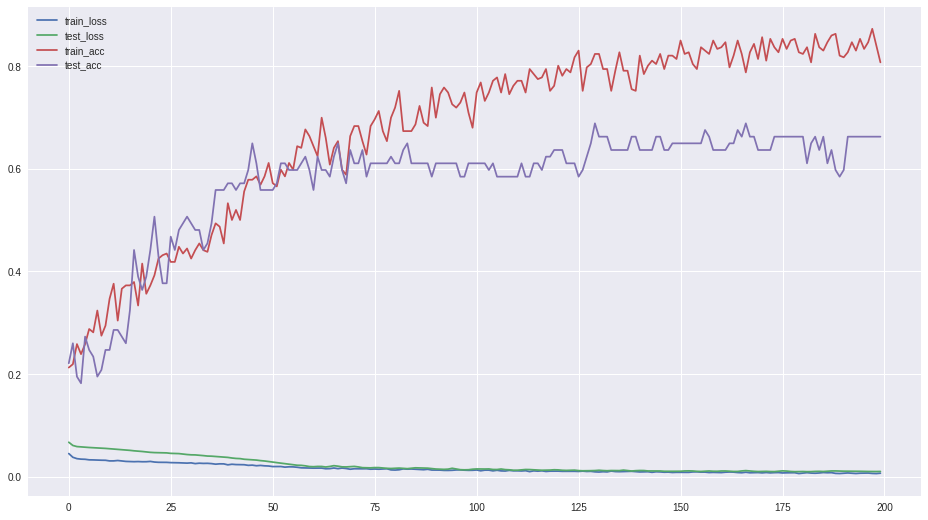

In [0]:
# plot history
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.plot(history.history['acc'], label='train_acc')
pyplot.plot(history.history['val_acc'], label='test_acc')

pyplot.rcParams["figure.figsize"] = [16, 9]
pyplot.legend()
pyplot.show()

## Predict with model

### Data reparation for Predictions

In [0]:
predict_vals = predict_in_arr



yhat = model.predict(predict_vals)

print yhat.shape



final = yhat[:,-1]

write_data = read_csv('/content/drive/Python/yds_test2018.csv', header=0, index_col=0)

write_data['Sales']  = final



write_data.to_csv('/content/drive/Python/results.csv')
 

(105, 6)


In [0]:
!rm drive/Python/Models/forecast*.hdf5